In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [2]:
data = yf.download("^GSPC", start="2018-01-01", end="2025-07-25")

price =  data['Close']

price.rename(columns={'^GSPC' : 'SP500'}, inplace=True )

price.head()

/var/folders/40/s4f2hrxs7sd19qb8q2_3j3fm0000gn/T/ipykernel_89460/2889423115.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2018-01-01", end="2025-07-25")
[*********************100%***********************]  1 of 1 completed
/var/folders/40/s4f2hrxs7sd19qb8q2_3j3fm0000gn/T/ipykernel_89460/2889423115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price.rename(columns={'^GSPC' : 'SP500'}, inplace=True )


Ticker,SP500
Date,
2018-01-02,2695.810059
2018-01-03,2713.060059
2018-01-04,2723.989990
2018-01-05,2743.149902
2018-01-08,2747.709961


#### Compute daily log returns for SP500

In [3]:
returns = np.log(price/price.shift(1)).dropna()

returns.head()

Ticker,SP500
Date,
2018-01-03,0.006378
2018-01-04,0.004021
2018-01-05,0.007009
2018-01-08,0.001661
2018-01-09,0.001302


#### Plot SP500 daily log returns



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


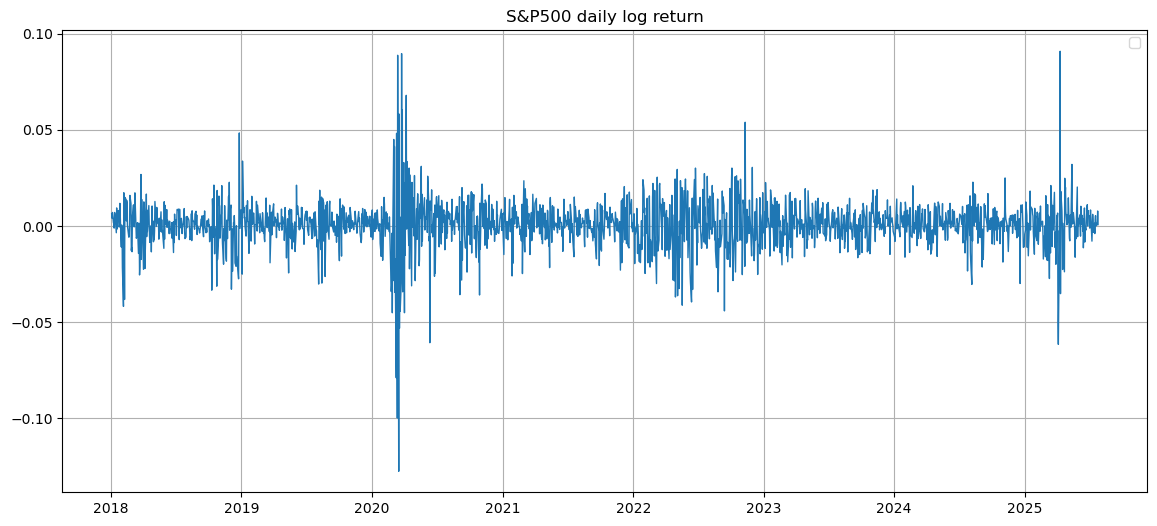

In [4]:
fig, ax = plt.subplots(figsize =(14,6))

x = returns.index
y= returns['SP500']

ax.plot(x,y, linewidth=1)
ax.set_title("S&P500 daily log return")
ax.legend()

plt.grid(True)
plt.show()

In [5]:
## Descriptive stats

print(returns.describe())

Ticker        SP500
count   1899.000000
mean       0.000452
std        0.012622
min       -0.127652
25%       -0.004611
50%        0.000898
75%        0.006711
max        0.090895


#### Checking for stationarity using Augmented Dickey Fullter test

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(returns)

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("The return series is stationary.")
else:
    print("The return series is not stationary.")


ADF Statistic: -13.62548916333653
p-value: 1.7634550202137705e-25
The return series is stationary.


In [7]:
#### Analyze volatility clustering



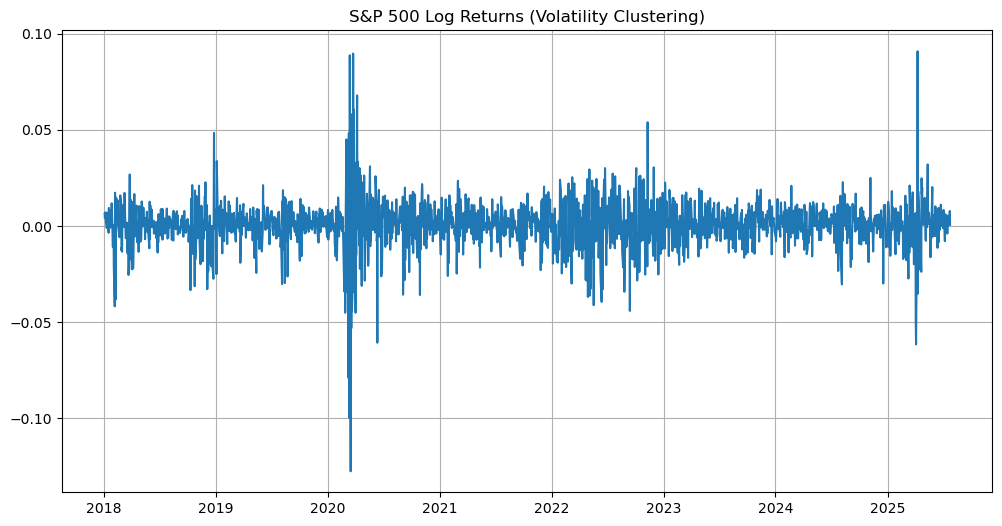

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(returns)

ax.set_title("S&P 500 Log Returns (Volatility Clustering)")

plt.grid()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


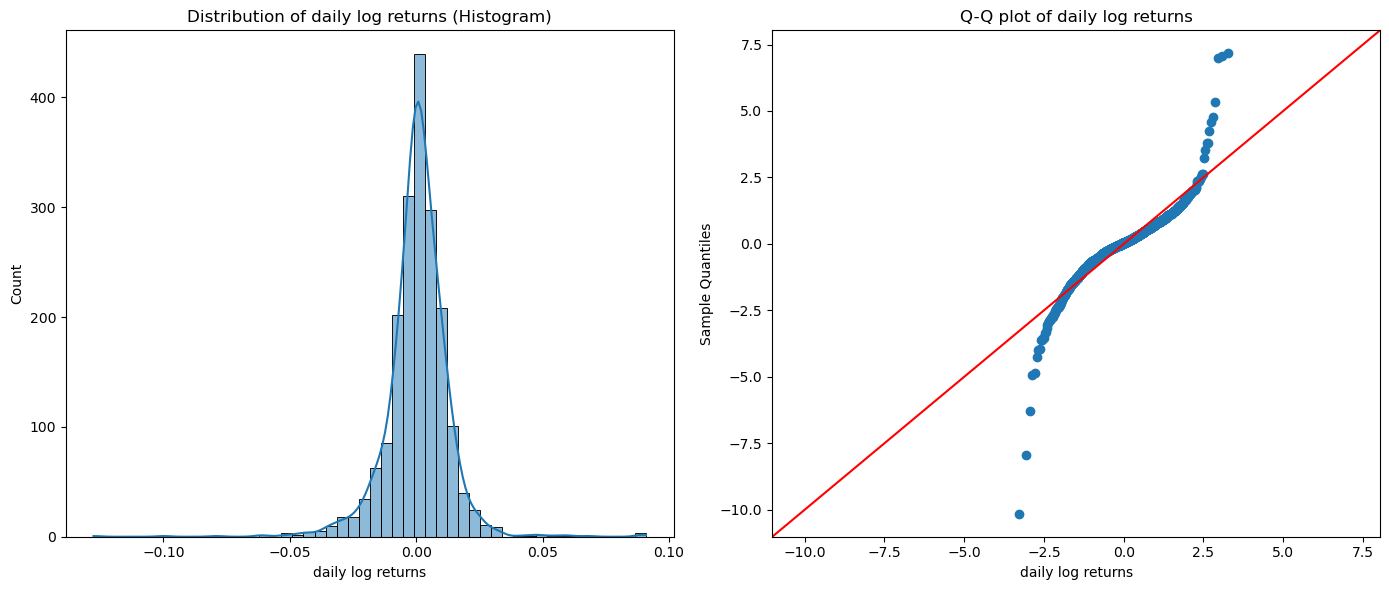

In [9]:


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

data = returns['SP500']



sns.histplot(data, bins=50, kde=True, ax=ax1)
sm.qqplot(returns['SP500'], line='45', fit=True, ax=ax2)

ax1.set_title('Distribution of daily log returns (Histogram)')
ax2.set_title('Q-Q plot of daily log returns')
ax1.set_xlabel('daily log returns')
ax2.set_xlabel('daily log returns')

plt.tight_layout()
plt.show()

#### Daily squared log returns are autocorrelated. 

#### There are periods where squared log returns stays consistently low (Low Volatility) Followed by a bursts of cluster where squared log returns remain high for some time (High Volatility).

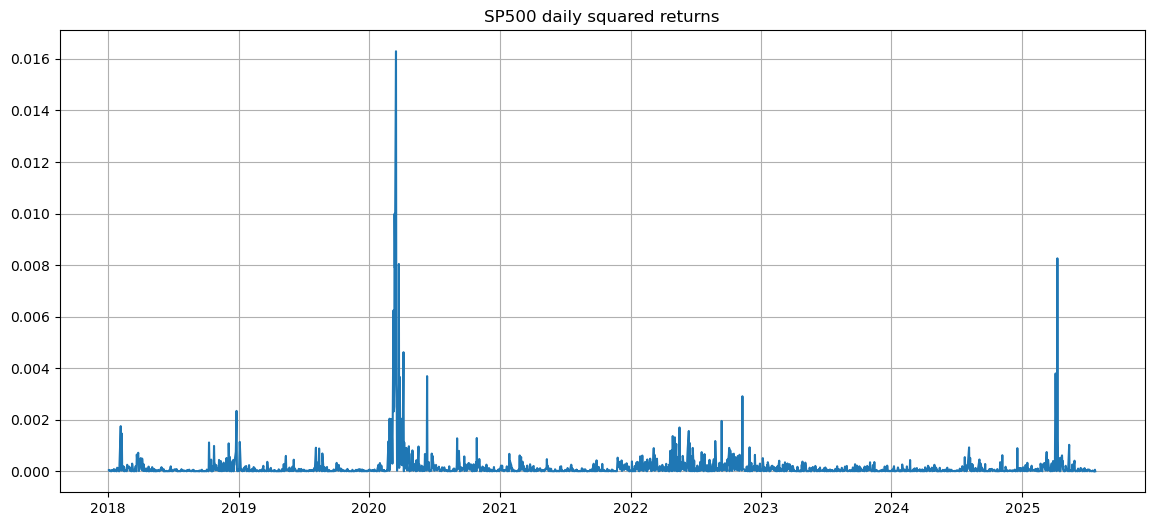

In [10]:
squared_returns = returns**2

fig, ax  = plt.subplots(figsize=(14,6))

x = squared_returns.index
y = squared_returns['SP500']

ax.plot(x,y, label = "squared returns")
ax.set_title("SP500 daily squared returns")

plt.grid()
plt.show()

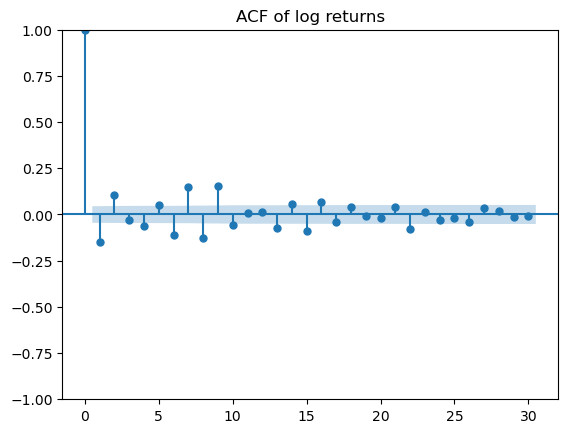

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(returns, lags=30, title="ACF of log returns")


plt.show()

The autocorrelation function (ACF) of log returns is close to zero at all lags (except lag 0).

Most of the bars fall within the blue confidence bands → this means no significant autocorrelation.

Log returns are uncorrelated, which aligns with the Efficient Market Hypothesis (EMH) — price changes are random and unpredictable.

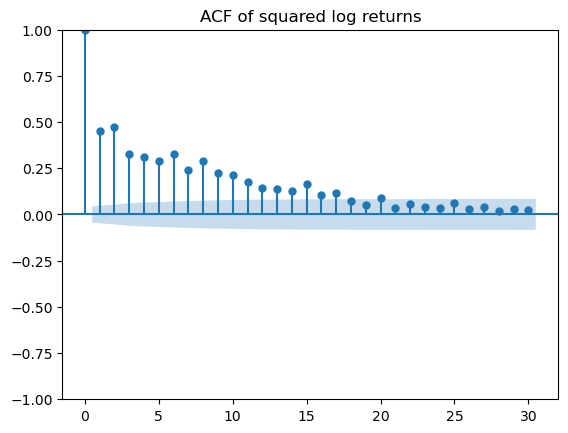

In [12]:
plot_acf(squared_returns, lags=30, title="ACF of squared log returns")

plt.show()

The ACF of squared log returns shows significant positive autocorrelation for many lags.

The bars gradually decay instead of being randomly scattered, and many of them lie outside the blue confidence bands.

This is evidence of volatility clustering — periods of high volatility are likely to be followed by high volatility (and vice versa)


### Conclusion

Squared log returns → autocorrelated → suitable for modeling conditional heteroskedasticity (volatility dynamics).

The squared lof returns result confirm that modeling volatility using an ARCH is appropriate here.

In [13]:
from arch import arch_model


In [14]:
returns_percentage = returns.dropna()*100

model = arch_model(returns_percentage, mean = 'AR', lags=1, vol='GARCH', p=1, q=1)
res = model.fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 30769.138415833353
Iteration:      2,   Func. Count:     19,   Neg. LLF: 11608.363894397327
Iteration:      3,   Func. Count:     30,   Neg. LLF: 29968548009.417572
Iteration:      4,   Func. Count:     39,   Neg. LLF: 5123.2589171583295
Iteration:      5,   Func. Count:     48,   Neg. LLF: 4517.071948903313
Iteration:      6,   Func. Count:     55,   Neg. LLF: 2662.343528556884
Iteration:      7,   Func. Count:     61,   Neg. LLF: 2662.3352682664154
Iteration:      8,   Func. Count:     67,   Neg. LLF: 2662.335259443635
Iteration:      9,   Func. Count:     72,   Neg. LLF: 2662.335259443869
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2662.335259443635
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 9
                           AR - GARCH Model Results                           
Dep. Variable:                  SP500   R-squared:           

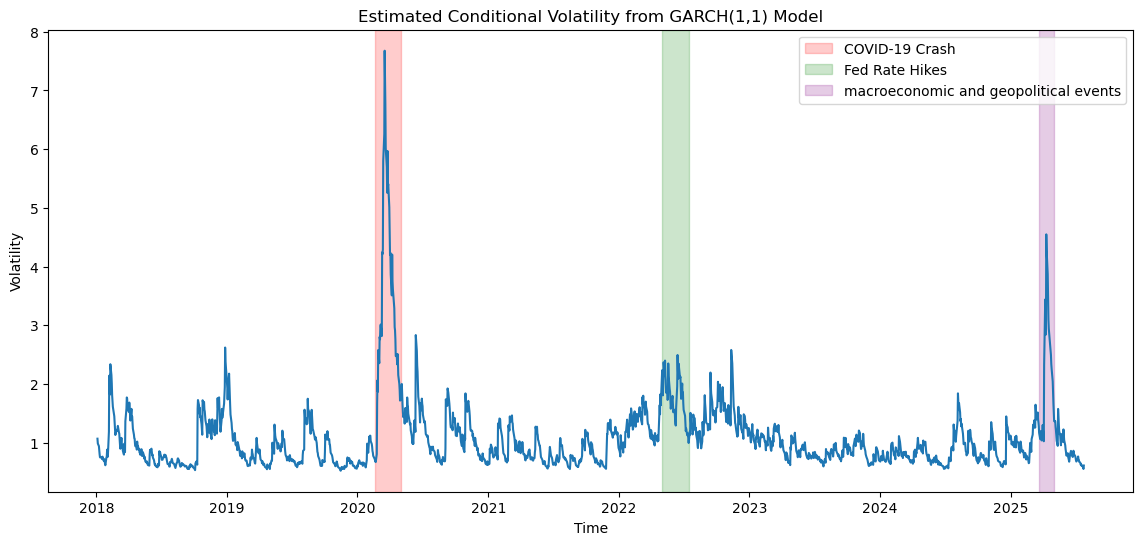

In [15]:
fig,ax  = plt.subplots(figsize=(14,6))

ax.plot(res.conditional_volatility)

ax.set_title("Estimated Conditional Volatility from GARCH(1,1) Model")
ax.set_xlabel("Time")
ax.set_ylabel("Volatility")



highlight_periods = [
    ("2020-02-20", "2020-05-01", "COVID-19 Crash", 'red'),
    ("2022-05-01", "2022-07-15", "Fed Rate Hikes", 'green'),
    ("2025-03-20", "2025-05-01", "macroeconomic and geopolitical events", 'purple'),
]

for start_date, end_date, label, color in highlight_periods:
    plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), 
                color=color, alpha=0.2, label=label)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.show()

### ARCH(1) model diagnostics

#### ACF of standardized residuals 

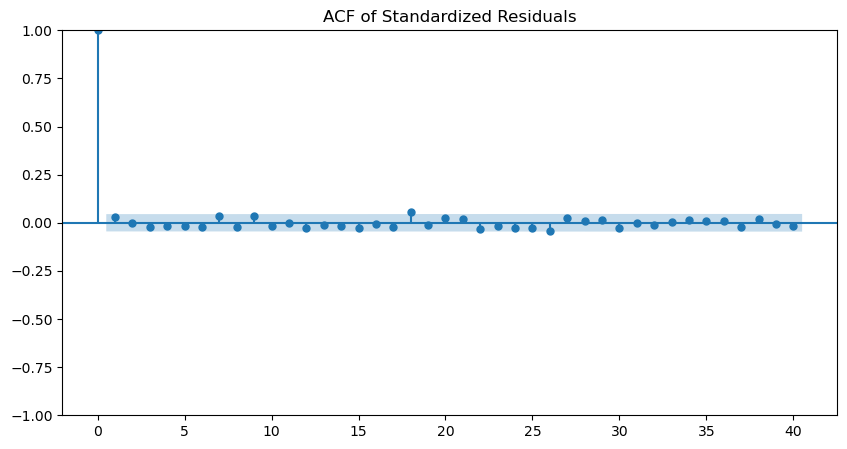

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

standard_residual = res.std_resid.dropna()

fig, ax = plt.subplots(figsize=(10,5))


plot_acf(standard_residual, lags=40, ax=ax)

ax.set_title("ACF of Standardized Residuals")

plt.show()


#### ACF of Squared Standardized Residuals

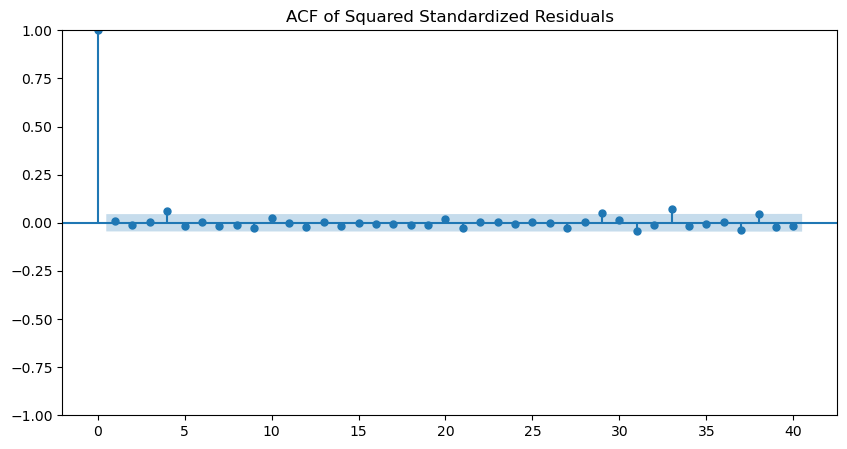

In [17]:
fig, ax = plt.subplots(figsize=(10,5))


plot_acf(standard_residual**2, lags=40, ax=ax)

ax.set_title("ACF of Squared Standardized Residuals")

plt.show()

#### Ljung Box test for Autocorrelation

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox


std_res_lb_test = acorr_ljungbox(standard_residual, lags=[10], return_df=True)
std_res_sq_lb_test = acorr_ljungbox(standard_residual**2, lags=[10], return_df=True)



print(f"p-value of standard residuals : {std_res_lb_test['lb_pvalue']}")
print(f"p-value of squared standard residuals : {std_res_sq_lb_test['lb_pvalue']}")


p-value of standard residuals : 10    0.441596
Name: lb_pvalue, dtype: float64
p-value of squared standard residuals : 10    0.272592
Name: lb_pvalue, dtype: float64


#### Forecasting volatility

In [37]:
horizon = 10
forecast_dates = pd.date_range(start=returns.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
forecast = res.forecast(horizon=horizon)
vol_forecast = np.sqrt(forecast.variance.values[-1])
print(vol_forecast)


[0.58545347 0.61722491 0.646161   0.67308009 0.69823763 0.72183787
 0.74404792 0.76500672 0.78483143 0.80362201]


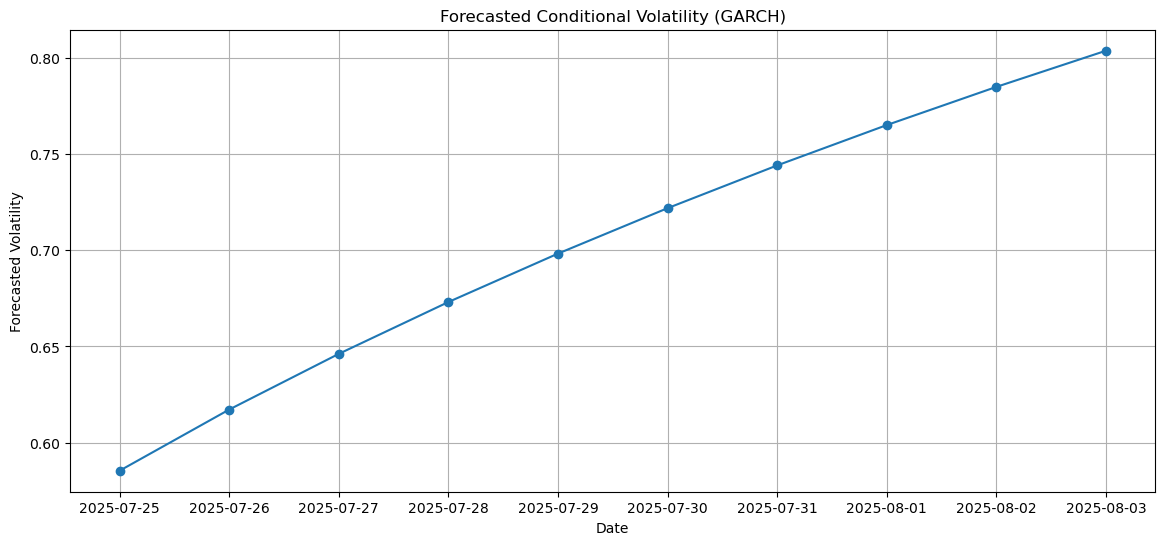

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(forecast_dates, vol_forecast, marker='o')

ax.set_title("Forecasted Conditional Volatility (GARCH) for 10 days")
ax.set_xlabel("Date")
ax.set_ylabel("Forecasted Volatility")
ax.grid(True)
plt.show()

plt.show()

In [72]:
historical_vol = res.conditional_volatility.dropna()
vol_forecast=pd.Series(vol_forecast, index=forecast_dates)

merge_vol = pd.concat([historical_vol, vol_forecast])

merege_vol = merge_vol['2025-01-01':]


print(vol_forecast.index[0])

2025-07-25 00:00:00


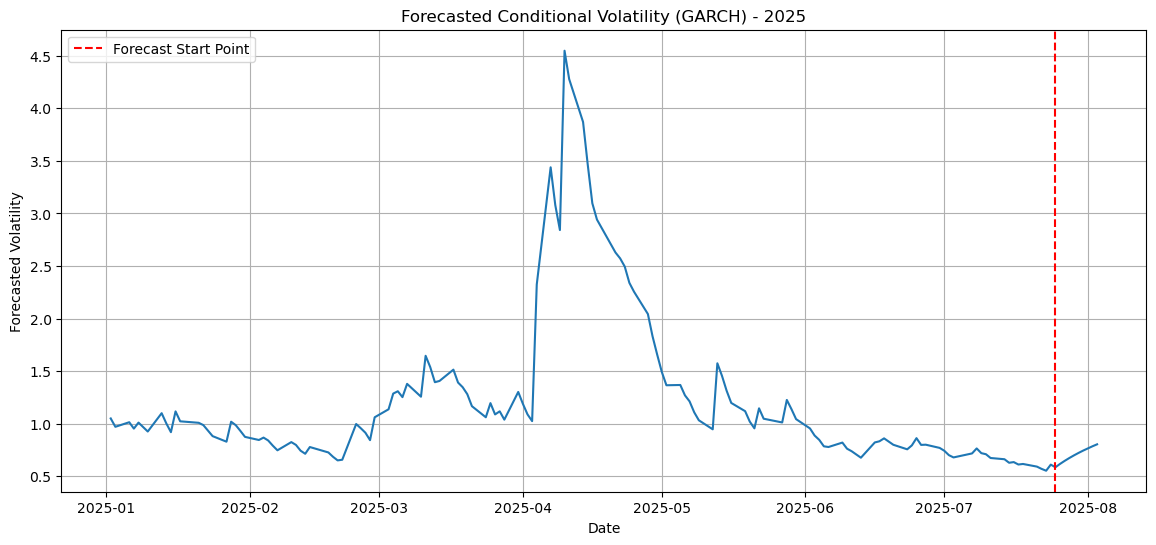

In [ ]:

historical_vol = res.conditional_volatility.dropna()
vol_forecast=pd.Series(vol_forecast, index=forecast_dates) #convert ndarray to pd series

vol_forecast_dt = vol_forecast.index[0]

merge_vol = pd.concat([historical_vol, vol_forecast])

merge_vol = merge_vol['2025-01-01': ]


fig, ax = plt.subplots(figsize=(14,6))

ax.plot(merge_vol)

ax.axvline(x=vol_forecast_dt, color='red', linestyle = '--', label='Forecast Start Point')

ax.set_title("Forecasted Conditional Volatility (GARCH) - 2025")
ax.set_xlabel("Date")
ax.set_ylabel("Forecasted Volatility")
ax.grid(True)
plt.legend()
plt.show()